# 6. Object Detection with DL

Outline:

1. Creating an image with multiple MNIST digits
2. Train a multiclass CNN on MNIST
3. Selective Search for Object Recognition
4. Get predictions on each detected object bounding box
5. Non-maximum supression
6. Putting it all together

In this notebook you will learn the fundamentals of object detection with Region-based Convolutional Neural Networks (R-CNNs). R-CNNs combine region proposals with convolutional neural networks (CNNs). They use selective search to first identify potential object regions in an image and then apply CNNs to classify these regions. R-CNNs have evolved into faster and more efficient versions, like Fast R-CNN and Faster R-CNN, which streamline the process and improve computational efficiency.

The other prominent object detection approach is YOLO (You Only Look Once), which divides the image into a grid and predicts bounding boxes and class probabilities for these boxes in a single pass through the neural network. This makes YOLO extremely fast, as it processes the entire image in one go. YOLO also have evolved, indicated by a version number (YOLO v2, v3 etc.)

For real time object detection, a YOLO based approach is preferred. For accuracy, an R-CNN based approach is preferred.

In this notebook we will cover the basic R-CNN. If you want to extend your knowledge in object detection, take a look at Fast and Faster R-CNN as well as YOLO.

We will create an image based on MNIST that contains 4 digits. Then, we will implement an R-CNN and run it on this image.

<img src='images/rcnn_output.png' width=600>

## 1. Creating an image with multiple MNIST digits

In [12]:
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [13]:
x_test_canvas = x_test.copy()

In [14]:
def create_canvas():
    canvas_size = 200
    canvas_mid = int(canvas_size/2)
    
    # black canvas
    canvas = np.zeros((canvas_size, canvas_size))

    for i in range(2):
        for j in range(2):
            # select a random digit
            random_id = np.random.randint(0, 10000)
            random_digit_image = x_test_canvas[random_id]
            # resize it
            random_size = np.random.randint(14, 56)
            random_digit_image = cv2.resize(random_digit_image, (random_size, random_size), interpolation = cv2.INTER_AREA)
            # place it on the canvas
            # one image in each quadrant
            random_x = np.random.randint(canvas_mid*i, canvas_mid*i + canvas_mid - random_size)
            random_y = np.random.randint(canvas_mid*j, canvas_mid*j + canvas_mid - random_size)
            canvas[random_y:random_y+random_size, random_x:random_x+random_size] = random_digit_image

    # convert it to 3 channel
    # because selective search requires 3 channels
    canvas = np.stack((canvas,)*3, axis=-1)
    canvas = canvas.astype(dtype=np.uint8)
    return canvas

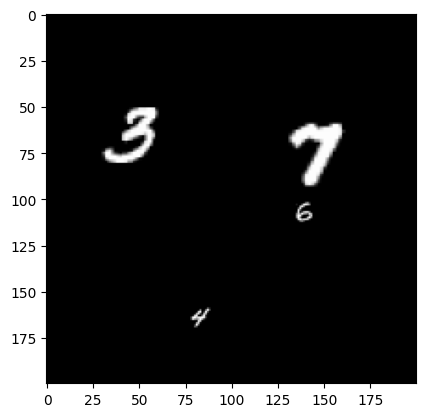

In [15]:
# Run this cell a few times to see different outputs
canvas = create_canvas()
plt.imshow(canvas)

## 2. Train a multiclass CNN on MNIST.

**Exercise 6.1**

You have learned how to build a CNN for classification in Y1C. Build one for the MNIST dataset. Use data augmentation with horizontal/vertical shifts as well as zoom ins and outs. This will be helpful because selective search might not return a bounding box where the digit is at the center, and digit size can be slightly different.

The model I developed obtained an accuracy between 98-99 % on the test set. The example results in the next sections will come from this model.

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

from tensorflow.keras.utils import to_categorical
import numpy as np

In [18]:
# YOUR CODE HERE
# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Data Augmentation 

datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
datagen.fit(x_train)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape = (28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'), 
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(datagen.flow(x_train, y_train), validation_data=(x_test, y_test), 
epochs=10,
    verbose=2)

Epoch 1/10
1875/1875 - 21s - 11ms/step - accuracy: 0.8630 - loss: 0.4193 - val_accuracy: 0.9759 - val_loss: 0.0755
Epoch 2/10
1875/1875 - 19s - 10ms/step - accuracy: 0.9544 - loss: 0.1477 - val_accuracy: 0.9840 - val_loss: 0.0467
Epoch 3/10
1875/1875 - 20s - 11ms/step - accuracy: 0.9659 - loss: 0.1081 - val_accuracy: 0.9891 - val_loss: 0.0362
Epoch 4/10
1875/1875 - 19s - 10ms/step - accuracy: 0.9721 - loss: 0.0914 - val_accuracy: 0.9823 - val_loss: 0.0559
Epoch 5/10
1875/1875 - 18s - 10ms/step - accuracy: 0.9756 - loss: 0.0808 - val_accuracy: 0.9849 - val_loss: 0.0516
Epoch 6/10
1875/1875 - 19s - 10ms/step - accuracy: 0.9777 - loss: 0.0738 - val_accuracy: 0.9900 - val_loss: 0.0339
Epoch 7/10
1875/1875 - 19s - 10ms/step - accuracy: 0.9795 - loss: 0.0672 - val_accuracy: 0.9890 - val_loss: 0.0356
Epoch 8/10
1875/1875 - 20s - 11ms/step - accuracy: 0.9816 - loss: 0.0630 - val_accuracy: 0.9923 - val_loss: 0.0272
Epoch 9/10
1875/1875 - 20s - 11ms/step - accuracy: 0.9826 - loss: 0.0588 - val_a

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.031358733773231506
Test accuracy: 0.9900000095367432


## 3. Selective Search for Object Recognition

"Selective Search for Object Recognition" is a seminal paper in computer vision for object recognition. It is authored by J.R.R. Uijlings, K.E.A. van de Sande, T. Gevers, and A.W.M. Smeulders in University of Amsterdam.

Please read the paper to understand how it works.

Abstract

>This paper addresses the problem of generating possible object lo- cations for use in object recognition. We introduce Selective Search which combines the strength of both an exhaustive search and seg- mentation. Like segmentation, we use the image structure to guide our sampling process. Like exhaustive search, we aim to capture all possible object locations. Instead of a single technique to gen- erate possible object locations, we diversify our search and use a variety of complementary image partitionings to deal with as many image conditions as possible. Our Selective Search results in a small set of data-driven, class-independent, high quality locations, yielding 99% recall and a Mean Average Best Overlap of 0.879 at 10,097 locations. The reduced number of locations compared to an exhaustive search enables the use of stronger machine learning techniques and stronger appearance models for object recognition. In this paper we show that our selective search enables the use of the powerful Bag-of-Words model for recognition. The Selective Search software is made publicly available 1.

[Link to pdf](https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/UijlingsIJCV2013.pdf)

The algorithm is implemented in OpenCV as 

```cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()```

However this operation is not in the main modules, it is available in the full installation of OpenCV.

If you look [here](https://pypi.org/project/opencv-python/), you will see two options for installing OpenCV:

a. Packages for standard desktop environments (Windows, macOS, almost any GNU/Linux distribution)
1. Main modules package: `pip install opencv-python`
2. Full package (contains both main modules and contrib/extra modules): `pip install opencv-contrib-python` (check contrib/extra modules listing from OpenCV documentation)

If you don't have the full package, please install it.

**Exercise 6.2**

Write a function that takes in the canvas (200, 200, 3), applies selective search and returns the bounding boxes. Selective search returns bounding boxes in the `(x, y, w, h)` format, where `(x, y)` is the coordinates of the top left corner of the bounding box and `w` and `h` are the width and height of the bounding box. It returns a numpy array of shape `(num_of_bounding_boxes, 4)`.

In [20]:
def selective_search(canvas, search_method='Quality'):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    # YOUR CODE HERE
    ss.setBaseImage(canvas)

    # Set the search method: 'Quality' is more accurate but slower, 'Fast' is faster but less accurate
    if search_method == 'Fast':
        ss.switchToSelectiveSearchFast()
    elif search_method == 'Quality':
        ss.switchToSelectiveSearchQuality()

    # Run selective search and get bounding boxes
    bboxes = ss.process()  # Returns a list of rectangles in (x, y, w, h) format

    # Convert bounding boxes to numpy array
    bboxes_xywh = np.array(bboxes)
    # remove the canvas if it is detected
    mask = ~np.all(bboxes_xywh == [0, 0, 200, 200], axis=1)
    bboxes_xywh = bboxes_xywh[mask]

    return bboxes_xywh

In [21]:
import cv2
print(hasattr(cv2, 'ximgproc'))  # Should return Tru

True


In [22]:
bboxes_xywh = selective_search(canvas)
len(bboxes_xywh)

20

**Exercise 6.3**

Write a function takes an image and bounding boxes as input and plots the bounding boxes on the image.

<img src='images/exercise_6_3.png' width=300>

In [ ]:
import matplotlib.patches as patches

def bb_plotter(im, bboxes_xywh):
    
    # YOUR CODE HERE
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(im)

    # Iterate over bounding boxes and add them as rectangles
    for (x, y, w, h) in bboxes_xywh:
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Display the image with bounding boxes
    plt.axis('off')  # Turn off axes for better visualization
    plt.show()

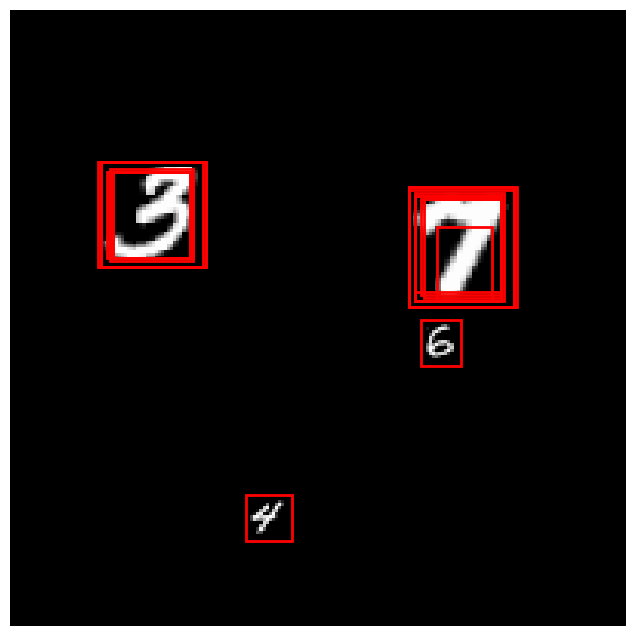

In [24]:
bb_plotter(canvas, bboxes_xywh)

## 4. Get predictions on each detected object bounding box

Let's get predictions for each bounding box. The first step for doing that is to crop the images and resize them to 28x28x1 as this is the input size our model expects.

**Exercise 6.4**

Write a function that accepts the canvas and the bounding boxes as input and returns the images in the bounding boxes with size `(number_of_bounding_boxes, 28, 28, 1)`, and normalized to the pixel values you have used to train the CNN.


In [59]:
def extract_and_resize_images_from_canvas(canvas, bboxes_xywh):
    detected_images = []
    for (x, y, w, h) in bboxes_xywh:
        # YOUR CODE HERE
        roi = canvas[y:y+h,x:x+w]
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        resized_roi = cv2.resize(gray_roi, (28, 28), interpolation=cv2.INTER_AREA)
        normalized_roi = resized_roi.astype('float32') / 255.0
        detected_images.append(normalized_roi[:,:, np.newaxis])

    detected_images = np.array(detected_images)
    detected_images = detected_images.reshape(-1, 28, 28, 1)
    return detected_images

In [60]:
detected_images = extract_and_resize_images_from_canvas(canvas, bboxes_xywh)

let's display 4 random images as a sanity check:

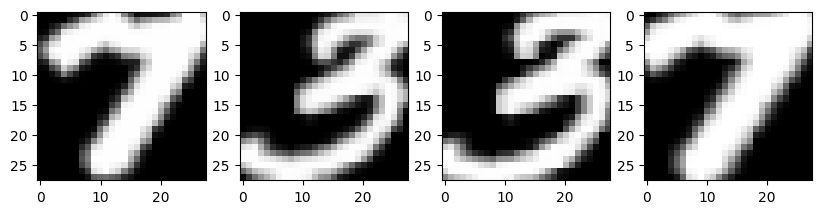

In [63]:
# I want to display four random bounding boxes
random_indices = np.random.choice(detected_images.shape[0], size=4, replace=False)
selected_images = detected_images[random_indices]

# Plotting the selected images
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for i, img in enumerate(selected_images):
    # Use squeeze() to remove the single-channel dimension
    axes[i].imshow(img.squeeze(), cmap='gray')

**Exercise 6.5**

Write a function that returns the predicted digit and its probability for each bounding box.

Now run `model.predict()` on the detected images and get the predicted digit and its probability:

In [64]:
def get_predictions(detected_images):
    preds = model.predict(detected_images)
    # YOUR CODE HERE
    digit_index = []
    digit_prob = []
    for pred in preds:
        max_prob_index = np.argmax(pred)
        max_prob = pred[max_prob_index]
        digit_index.append(max_prob_index)
        digit_prob.append(max_prob)


    return digit_index, digit_prob

In [65]:
digit_index, digit_prob = get_predictions(detected_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [66]:
df = pd.DataFrame([digit_prob, digit_index]).T
df.columns = ['Probability', 'Predicted Digit']
df.head()

,Probability,Predicted Digit
0,0.999279,3.0
1,1.000000,3.0
2,0.995323,7.0
3,0.999485,7.0
4,0.999678,4.0


let's display 4 random images as a sanity check, this time with prediction results:

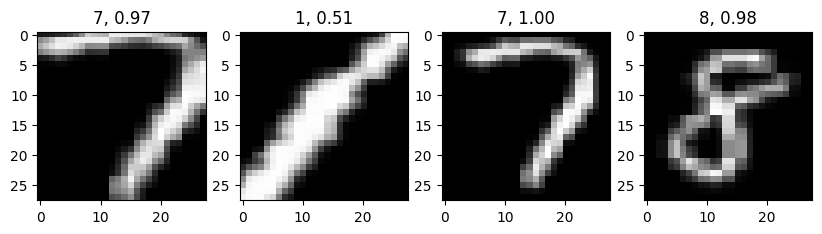

In [148]:
# I want to display four random bounding boxes
digit_index = np.array(digit_index)
digit_prob = np.array(digit_prob)

random_indices = np.random.choice(detected_images.shape[0], size=4, replace=False)
selected_images = detected_images[random_indices]

# get predictions and probabilities
selected_images_digits = digit_index[random_indices]
selected_images_probs = digit_prob[random_indices]

# Plotting the selected images
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for i, img in enumerate(selected_images):
    title_text = f'{selected_images_digits[i]}, {selected_images_probs[i]:.2f}'
    # Use squeeze() to remove the single-channel dimension
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(title_text)

## 5. Non-maximum supression (NMS)

The final problem we need to address is the multiple bounding boxes around a single digit. How can we find the best one?

The algorithm we will use to do that is called non-maximum supression. Here's how it works:

1. **Many Bounding Boxes**: Selective search will probably detect several bounding boxes around the same object. These boxes can vary slightly in size and position.

2. **Scores for Each Box**: We run all these boxes through a classification model to obtain a score (probability) indicating the confidence level that the box contains the target object.

3. **Best Box Selection**: Non-maximum suppression starts by selecting the box with the highest score, known as the "current best box".

4. **Intersection over Union (IoU)**: IoU is a measure used to quantify the overlap between two bounding boxes. It divides the area of overlap between two boxes by the area of union (total area covered by both boxes). A higher IoU means more overlap.

5. **Compare and Eliminate**: The algorithm then compares the IoU of the "current best box" with all other boxes. If another box has a high IoU with the "current best box" (above a certain threshold), it's likely detecting the same object and is discarded.

6. **Repeat the Process**: The process is repeated – selecting the next highest scoring box and removing all boxes overlapping significantly with it, based on the IoU threshold. This continues until all boxes are either selected as a "best box" or discarded.

7. **Final Result**: In the ideal scenario, each detected object in the image is represented by only one box – the one that the algorithm was most confident about.

In summary, NMS uses the IoU metric to compare and filter overlapping bounding boxes, keeping only the most relevant ones for each detected object.

Before implementing NMS, let's implement IoU as a helper function. First read the following to understand what IoU is:

[Jaccard Index (Wikipedia)](https://en.wikipedia.org/wiki/Jaccard_index)

This picture shows clearly how to calculate IoU

<img src='https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png' width=300>

An IoU of zero means the bounding boxes do not overlap, and one means they overlap perfectly.

<img src='https://upload.wikimedia.org/wikipedia/commons/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png' width=300>

currently we have bounding boxes in `(x, y, w, h)` format. It is easier to implement IoU if we have top left corner coordinates and bottom right corner coordinates. Here is a helper function that will convert `(x, y, w, h)` to `(left, top, right, bottom)`:

In [149]:
def convert_xywh_to_ltrb(bboxes_xywh):
    '''
    This function takes in a list of bboxes
    where each bbox is a tuple (x, y, w, h)
    and creates a list of bboxes
    where each bbox is a tuple (left, top, right, bottom)
    '''
    bboxes_ltrb = []
    
    for (x, y, w, h) in bboxes_xywh:
        top = y
        left = x
        right = x + w
        bottom = y + h
        bboxes_ltrb.append((left, top, right, bottom))
    
    return bboxes_ltrb

In [150]:
bboxes_ltrb = convert_xywh_to_ltrb(bboxes_xywh)

**Exercise 6.6**

Given two bounding boxes in `(left, top, right, bottom)` format, implement a function that calculates IoU between these bounding boxes. The function should return zero if the boxes do not overlap.

In [151]:
def iou_calculator(bbox1, bbox2):
    l1, t1, r1, b1 = bbox1
    l2, t2, r2, b2 = bbox2
    import math
    # Find the intersection rectangle
    # YOUR CODE HERE
    inter_left = max(l1, l2)
    inter_top = max(t1, t2)
    inter_right = min(r1, r2)
    inter_bottom = min(b1, b2)
    # w and h of the intersection rectangle
    # YOUR CODE HERE
    inter_width = max(0, inter_right - inter_left)
    inter_height = max(0, inter_bottom - inter_top)
    # intersection area
    # YOUR CODE HERE
    intersection = inter_height * inter_width
    # areas of the bboxes
    # YOUR CODE HERE
    area1 = (r1 - l1) * (b1 - t1)
    area2 = (r2 - l2) * (b2 - t2)
    # union area
    # YOUR CODE HERE
    union = area1 + area2
    if union == 0:  # To avoid division by zero
        return 0
    return intersection / union

Now we are ready for implementing, NMS. Let's combine everything we calculated for each bbox, and sort by probability:

In [152]:
bboxes_with_score = [(digit_prob[i], digit_index[i], tuple(bboxes_xywh[i]), bboxes_ltrb[i]) for i in range(len(bboxes_xywh))]
bboxes_with_score.sort(reverse=True)
df = pd.DataFrame(bboxes_with_score, columns=['Probability', 'Predicted Digit', 'x, y, w, h', 'l, t, r, b'])
df.head(n=10)

,Probability,Predicted Digit,"x, y, w, h","l, t, r, b"
0,0.999999,4,"(63, 11, 20, 26)","(63, 11, 83, 37)"
1,0.999997,4,"(63, 12, 20, 24)","(63, 12, 83, 36)"
2,0.999967,4,"(66, 14, 14, 20)","(66, 14, 80, 34)"
3,0.999631,7,"(128, 140, 28, 40)","(128, 140, 156, 180)"
4,0.999518,8,"(29, 160, 14, 17)","(29, 160, 43, 177)"
5,0.999480,7,"(129, 140, 27, 40)","(129, 140, 156, 180)"
6,0.999329,7,"(129, 140, 27, 39)","(129, 140, 156, 179)"
7,0.998503,8,"(28, 160, 15, 17)","(28, 160, 43, 177)"
8,0.998366,7,"(129, 140, 26, 39)","(129, 140, 155, 179)"
9,0.997206,7,"(131, 142, 22, 35)","(131, 142, 153, 177)"


**Exercise 6.7**

Implement NMS. It should take the list `bboxes_with_score` created above and return a single bounding box per digit.

- select the first box (highest prob)
- find all the boxes that overlap with this box above a certain IoU and remove them
- repeat this process with the remaining boxes, until no box is left.

In [161]:
def nms(bboxes_with_score):
    selected_bboxes = []
    while len(bboxes_with_score) > 0:
        # Select the box with the highest score (probability)
        best_box = bboxes_with_score[0]
        selected_bboxes.append(best_box)

        # Remove the selected box from the list
        bboxes_with_score = bboxes_with_score[1:]

        # Filter out boxes that overlap too much with the selected box
        remaining_boxes = []
        for box in bboxes_with_score:
            iou = iou_calculator(best_box[3], box[3])  # Compare (l, t, r, b) format
            if iou < 0.5:
                remaining_boxes.append(box)

        # Update the list of boxes to process
        bboxes_with_score = remaining_boxes
    return selected_bboxes

In [162]:
df = pd.DataFrame(selected_bboxes, columns=['Probability', 'Predicted Digit', 'x, y, w, h', 'l, t, r, b'])
df

,Probability,Predicted Digit,"x, y, w, h","l, t, r, b"


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

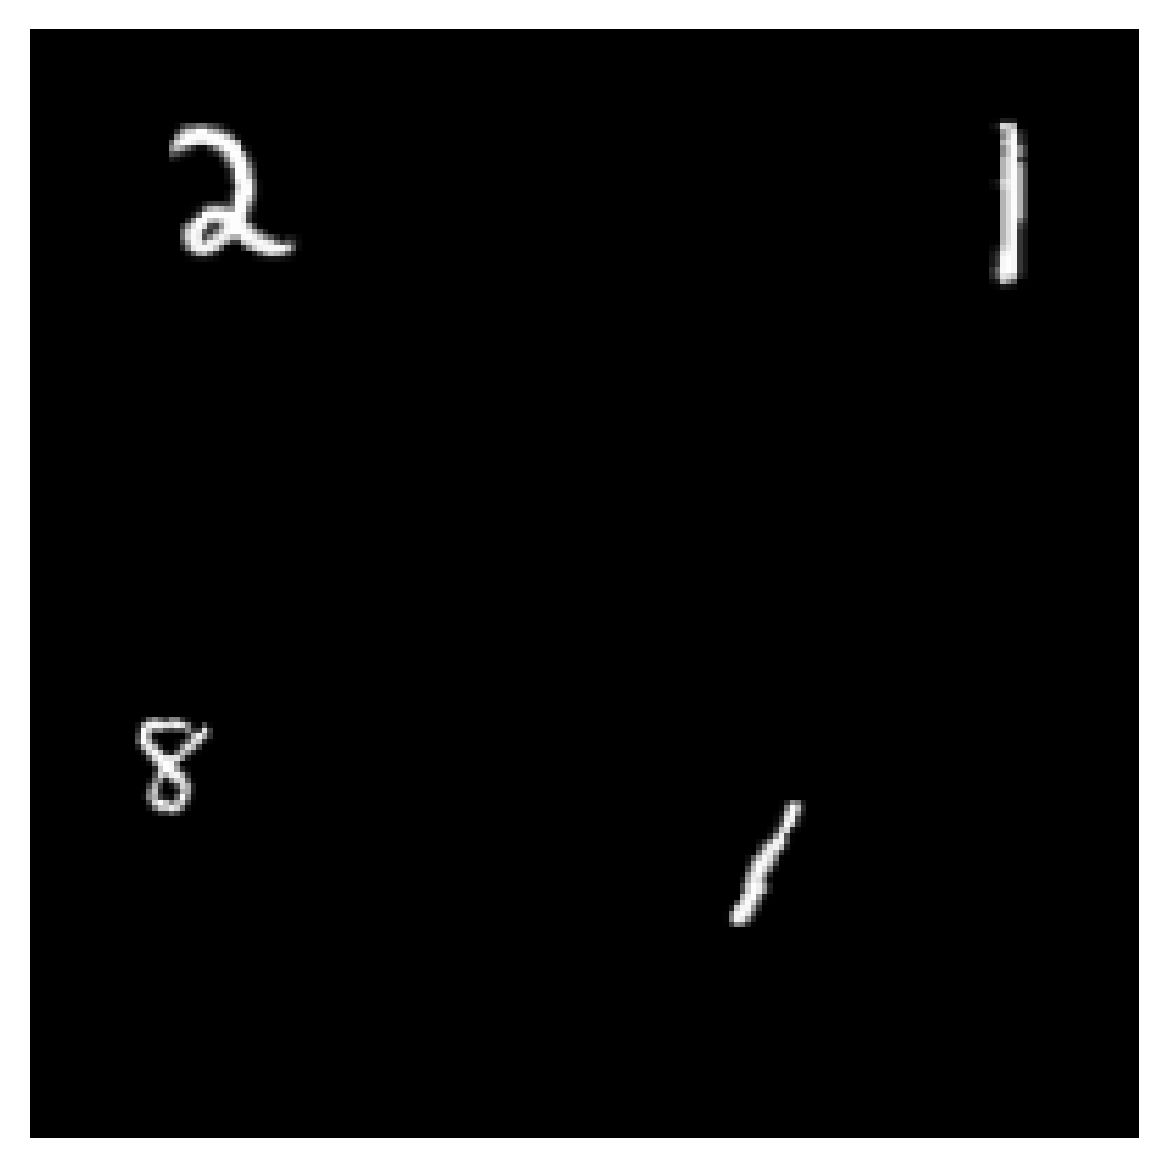

In [163]:
fig, ax = plt.subplots(dpi=300)
ax.imshow(canvas)
for prob, digit, (x, y, w, h), _ in selected_bboxes:
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    text_on_box  = f'{digit}'
    ax.text(x, y, text_on_box, color='white')
ax.axis('off')

## 6. Putting it all together

In [164]:
canvas = create_canvas()
bboxes_xywh = selective_search(canvas)
bboxes_ltrb = convert_xywh_to_ltrb(bboxes_xywh)
detected_images = extract_and_resize_images_from_canvas(canvas, bboxes_xywh)
digit_index, digit_prob = get_predictions(detected_images)
bboxes_with_score = [(digit_prob[i], digit_index[i], tuple(bboxes_xywh[i]), bboxes_ltrb[i]) for i in range(len(bboxes_xywh))]
bboxes_with_score.sort(reverse=True)
selected_bboxes = nms(bboxes_with_score)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

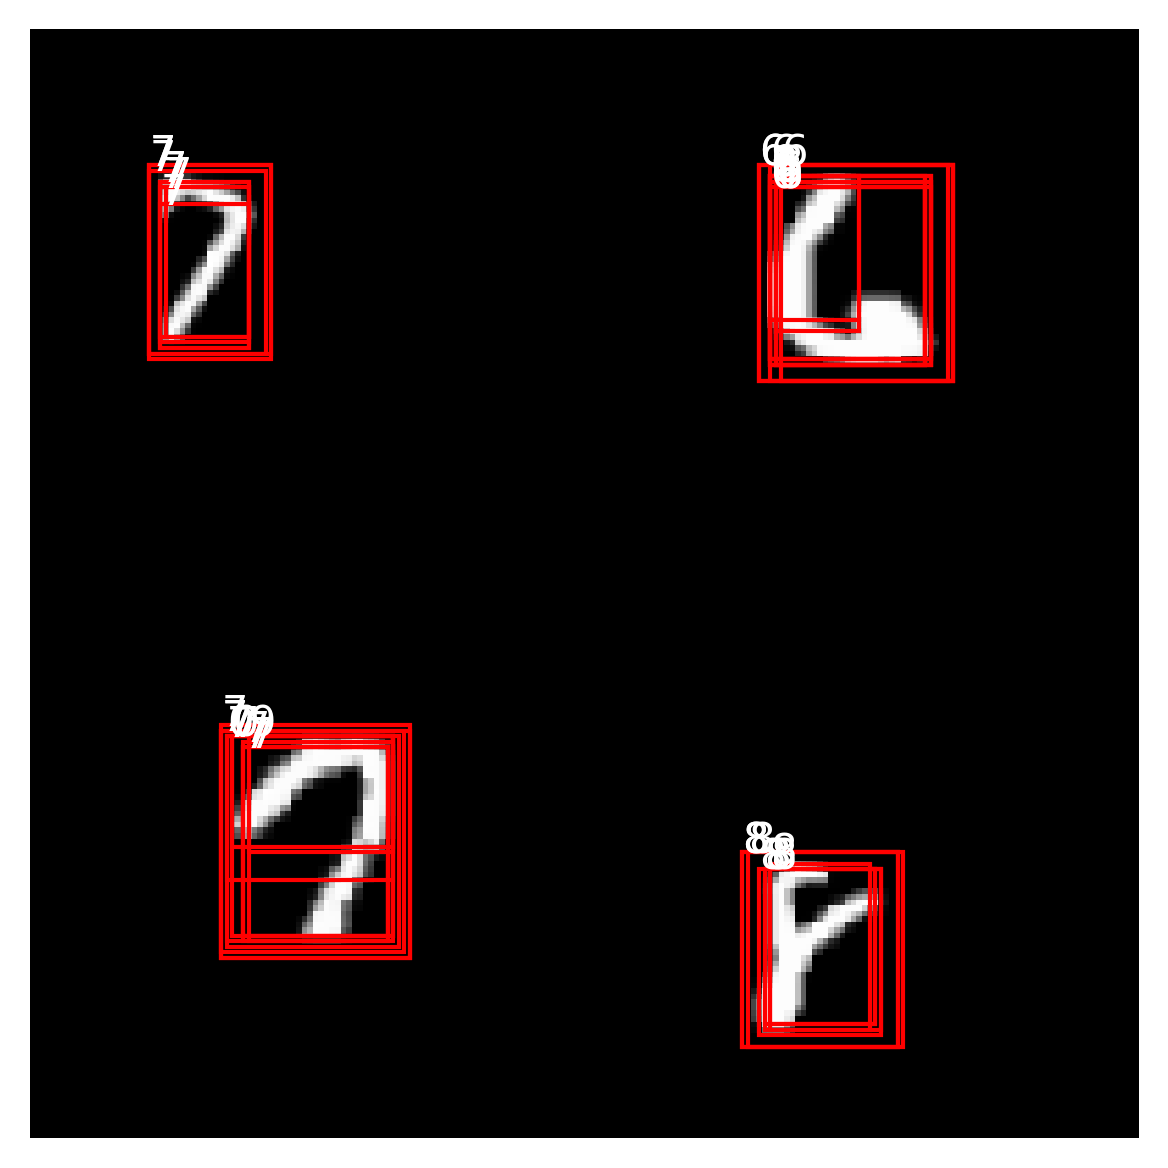

In [165]:
fig, ax = plt.subplots(dpi=300)
ax.imshow(canvas)
for prob, digit, (x, y, w, h), _ in selected_bboxes:
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    text_on_box  = f'{digit}'
    ax.text(x, y, text_on_box, color='white')
ax.axis('off')